In [123]:
import mdtraj as md
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
import pandas as pd

In [2]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

sns.set_style("whitegrid")

In [124]:
#block function from pyblock package -  https://github.com/jsspencer/pyblock
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
    #    print("Warning: Data size = %g, is not a power of 2." % floor(2**d))
    #    print("Truncating data to %g." % 2**floor(d) )
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances 
    # for each blocking transformation
    for i in arange(0,d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]

    # we need a list of magic numbers
    q =array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))


def free_energy_1D_blockerror(a,T,x0,xmax,bins,blocks):
  histo,xedges=np.histogram(a,bins=bins,range=[x0,xmax],density=True,weights=None)
  max=np.max(histo)  
  #free_energy=-(0.001987*T)*np.log(histo)
  free_energy=-(0.001987*T)*np.log(histo+.000001)
  free_energy=free_energy-np.min(free_energy)
  xcenters= xedges[:-1] + np.diff(xedges)/2
  Ind=chunkIt(len(a),blocks)
  block_size=(Ind[0][1]-Ind[0][0])
  #print("Block Size:", block_size,"Blocks:",blocks)
  hist_blocks=[]
  for i in range(0,len(Ind)):
   block_data=a[Ind[i][0]:Ind[i][1]]
   hist,binedges=np.histogram(block_data,bins=bins,range=[x0,xmax],density=True,weights=None)
   hist_blocks.append(hist)
  hist_blocks=np.array(hist_blocks)
  average=np.average(hist_blocks,axis=0)
  variance=np.var(hist_blocks,axis=0)
  N=len(hist_blocks)
  error = np.sqrt( variance / N ) 
  #ferr = (error / average)
  ferr = -(0.001987*T)*(error / average)
  return free_energy,xcenters,ferr

def chunkIt(a, num):
    avg = a / float(num)
    out = []
    last = 0.0
    while last < a-1:
        out.append([int(last),int(last+avg)])
        #out.append(seq[int(last):int(last + avg)])
        last += avg
    return out

def histo_blockerror(a,x0,xmax,bins,blocks):
  histo,xedges=np.histogram(a,bins=bins,range=[x0,xmax],density=True,weights=None)
  xcenters= xedges[:-1] + np.diff(xedges)/2
  Ind=chunkIt(len(a),blocks)
  block_size=(Ind[0][1]-Ind[0][0])
  hist_blocks=[]
  for i in range(0,len(Ind)):
   block_data=a[Ind[i][0]:Ind[i][1]]
   hist,binedges=np.histogram(block_data,bins=bins,range=[x0,xmax],density=True,weights=None)
   hist_blocks.append(hist)
  hist_blocks=np.array(hist_blocks)
  average=np.average(hist_blocks,axis=0)
  variance=np.var(hist_blocks,axis=0)
  N=len(hist_blocks)
  error = np.sqrt( variance / N ) 
  return average,xcenters,error

def Kd_calc(bound,conc):
  return((1-bound)*conc/bound)

def get_blockerrors(Data,bound_frac):
 n_data=len(Data[0])
 block_errors=[]
 ave=[]
 for i in range(0,n_data):
  data=Data[:,i]
  average=np.average(data)
  be=block(data)**.5
  ave.append(np.average(data))
  block_errors.append(be)
 ave_bf=np.asarray(ave)/bound_frac
 be_bf=np.asarray(block_errors)/bound_frac
   

 return ave_bf,be_bf

def get_blockerrors_pyblock(Data,bound_frac):
 n_data=len(Data[0])
 block_errors=[]
 ave=[]
 for i in range(0,n_data):
  data=Data[:,i]
  average=np.average(data)
  if (average!=0) and (average!=1):
    reblock_data = pyblock.blocking.reblock(data)
    opt = pyblock.blocking.find_optimal_block(len(data), reblock_data)[0]
    opt_block=reblock_data[opt] 
    #print("optimal block:",opt_block)
    #print(opt_block[2],opt_block[4])
    be=opt_block[4]
  else:
   be=0
  ave.append(average)
  block_errors.append(be)

 ave_bf=np.asarray(ave)/bound_frac
 be_bf=np.asarray(block_errors)/bound_frac
 return ave_bf,be_bf


def get_blockerror(Data):
  data=Data
  average=np.average(data)
  be=block(data)**.5
  return average,be

def get_blockerror_pyblock(Data):
  average=np.average(Data)
  #print(average,Data,len(Data))  
  if (average!=0) and (average!=1):
   reblock_data = pyblock.blocking.reblock(Data)
   opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
   be=reblock_data[opt][4]
  else:
   be=0
  return average,float(be)


def get_blockerror_pyblock_nanskip(Data):
  average=np.average(Data)
  #print(average,Data,len(Data))  
  if (average!=0) and (average!=1):
   reblock_data = pyblock.blocking.reblock(Data)
   opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
   #print(opt)
   #print(math.isnan(opt))
   if(math.isnan(opt)):
    be_max=0
    for i in range(0,len(reblock_data)): 
     be=reblock_data[i][4]
     if(be > be_max):
       be_max=be 
   else:
    be=reblock_data[opt][4] 
  else:
   be=0
  return average,float(be)

In [4]:
def calc_SA(trj,helix,start,stop):
 r0=.10
 RMS_start=start
 RMS_stop=stop
 RMS=[]
 for i in range(RMS_start,RMS_stop):
    sel=helix.topology.select("residue %s to %s and name CA" % (i,i+6))
    rmsd = md.rmsd(trj,helix,atom_indices=sel)
    RMS.append(rmsd)
 RMS=np.asarray(RMS)
 Sa_sum=np.zeros((trj.n_frames))
 Sa=(1.0-(RMS/0.10)**8)/(1-(RMS/0.10)**12)
 return Sa

def calc_Rg(trj):
 mass=[]
 for at in trj.topology.atoms:
    mass.append(at.element.mass)
 mass_CA = len(mass)*[0.0]
 for i in trj.topology.select("name CA"): mass_CA[i]=1.0
 rg_CA=md.compute_rg(trj, masses=np.array(mass_CA))
 return rg_CA

def free_energy(a,b,T,y0,ymax,x0,xmax):
  free_energy,xedges,yedges=np.histogram2d(a,b,30,[[y0,ymax],[x0,xmax]],normed=True,weights=None)
  free_energy=np.log(np.flipud(free_energy)+.000001)
  free_energy=-(0.001987*T)*free_energy
  return free_energy,xedges,yedges

def free_energy_reweight(a, b, T, y0, ymax, x0, xmax,weight):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=weight)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

def free_energy_1D_noscale(a,T,x0,xmax,bins):
  free_energy,xedges=np.histogram(a,bins=bins,range=[x0,xmax],density=True,weights=None)
  free_energy=np.log(free_energy+.000001)
  free_energy=-(0.001987*T)*free_energy
  xcenters= xedges[:-1] + np.diff(xedges)/2
  return free_energy,xcenters

def free_energy_1D(a,T,x0,xmax,bins):
  free_energy,xedges=np.histogram(a,bins=bins,range=[x0,xmax],density=True,weights=None)
  max=np.max(free_energy)  
  free_energy=np.log(free_energy+.0000001)
  free_energy=-(0.001987*T)*(free_energy-np.log(max+.0000001))
  xcenters= xedges[:-1] + np.diff(xedges)/2
  return free_energy,xcenters

def free_energy_1D_reweight(a, T, x0, xmax, bins,weight):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=weight)
    max = np.max(free_energy)
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*(free_energy-np.log(max+.0000001))
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters

def alphabeta_rmsd(phi,psi,phi_ref,psi_ref):
 alphabetarmsd=np.sum(0.5*(1+np.cos(psi-psi_ref)),axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)),axis=1)
 return alphabetarmsd 

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 SE_H=np.zeros((len(dssp[0]),2))

 for i in range(0,len(dssp[0])): 
     data=dsspH[:,i].astype(float) 
     if(np.mean(data)>0):
      SE_H[i]=[np.mean(data),(block(data))**.5] 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 SE_E=np.zeros((len(dssp[0]),2))

 for i in range(0,len(dssp[0])):
     data=dsspE[:,i].astype(float)
     if(np.mean(data)>0):
      SE_E[i]=[np.mean(data),(block(data))**.5]
 return SE_H, SE_E


def calc_phipsi(trj):
 indices_phi, phis = md.compute_phi(trj)
 indices_psi, psis = md.compute_psi(trj)
 phi_label=[]
 for i_phi in range(0, indices_phi.shape[0]):
      resindex=trj.topology.atom(indices_phi[i_phi][2]).residue.resSeq
      phi_label.append(resindex)
 phi_label=np.array(phi_label)
 #print(phi_label)
 psi_label=[]
 for i_psi in range(0, indices_psi.shape[0]):
      resindex=trj.topology.atom(indices_psi[i_psi][2]).residue.resSeq
      psi_label.append(resindex)
 psi_label=np.array(psi_label)
 #print(psi_label)
 phipsi=[]
 for i in range(0,len(phi_label)-1):
  current_phipsi=np.column_stack((phis[:,i+1],psis[:,i]))
  phipsi.append(current_phipsi)
 phipsi_array=np.array(phipsi)
 return(phipsi_array,psi_label,phi_label)

In [5]:
outdir='/Users/paulrobustelli/Desktop/Trajectories/AR_3.18.2021/R2_R3_Apo_12.20.21/'
pdb='/Users/paulrobustelli/Desktop/Trajectories/AR_3.18.2021/R2_R3_Apo_12.20.21/Trajectories/R2R3.apo.pdb'
rep0='/Users/paulrobustelli/Desktop/Trajectories/AR_3.18.2021/R2_R3_APO/Trajectories/Replica_fromXTC_0.xtc'
helixpdb='/Users/paulrobustelli/Desktop/Trajectories/AR_3.18.2021/R2_R3_Apo_12.20.21/Trajectories/R2R3_all_helix.pdb'

print("outdir:",outdir)
print("pdb:",pdb)
print("helix pdb:",helixpdb)
print("trjaectory:",rep0)

outdir: /Users/paulrobustelli/Desktop/Trajectories/AR_3.18.2021/R2_R3_Apo_12.20.21/
pdb: /Users/paulrobustelli/Desktop/Trajectories/AR_3.18.2021/R2_R3_Apo_12.20.21/Trajectories/R2R3.apo.pdb
helix pdb: /Users/paulrobustelli/Desktop/Trajectories/AR_3.18.2021/R2_R3_Apo_12.20.21/Trajectories/R2R3_all_helix.pdb
trjaectory: /Users/paulrobustelli/Desktop/Trajectories/AR_3.18.2021/R2_R3_APO/Trajectories/Replica_fromXTC_0.xtc


In [8]:
trj = md.load(rep0, top=pdb,stride=10)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [9]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
prot_top=top.subset(top.select('protein'))
prot_res=[]
for res in prot_top.residues: prot_res.append(res.resSeq)
prot_resname=(' %s' % [residue.name for residue in prot_top.residues])
residues=len(set(prot_res))

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)

residues=58
residue_offset=390
prot_res_renum=np.asarray(prot_res)+residue_offset
residue_number = range(0,residues)
residue_number_offsetres = range(residue_offset, residue_offset+residues)
print("Residue Number Range:",residue_number)

** SYSTEM INFO **

Number of atoms: 739

Number of residues: 58

Number of protein residues: 57

Number of frames: 5715

Starting frame: 0

Last frame: 5715

sequence:  [ACE0, LEU1, ASP2, TYR3, GLY4, SER5, ALA6, TRP7, ALA8, ALA9, ALA10, ALA11, ALA12, GLN13, CYS14, ARG15, TYR16, GLY17, ASP18, LEU19, ALA20, SER21, LEU22, HIS23, GLY24, ALA25, GLY26, ALA27, ALA28, GLY29, PRO30, GLY31, SER32, GLY33, SER34, PRO35, SER36, ALA37, ALA38, ALA39, SER40, SER41, SER42, TRP43, HIS44, THR45, LEU46, PHE47, THR48, ALA49, GLU50, GLU51, GLY52, GLN53, LEU54, TYR55, GLY56, NH257]

residue names:  ['ACE', 'LEU', 'ASP', 'TYR', 'GLY', 'SER', 'ALA', 'TRP', 'ALA', 'ALA', 'ALA', 'ALA', 'ALA', 'GLN', 'CYS', 'ARG', 'TYR', 'GLY', 'ASP', 'LEU', 'ALA', 'SER', 'LEU', 'HIS', 'GLY', 'ALA', 'GLY', 'ALA', 'ALA', 'GLY', 'PRO', 'GLY', 'SER', 'GLY', 'SER', 'PRO', 'SER', 'ALA', 'ALA', 'ALA', 'SER', 'SER', 'SER', 'TRP', 'HIS', 'THR', 'LEU', 'PHE', 'THR', 'ALA', 'GLU', 'GLU', 'GLY', 'GLN', 'LEU', 'TYR', 'GLY', 'NH2']

residue i

/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]


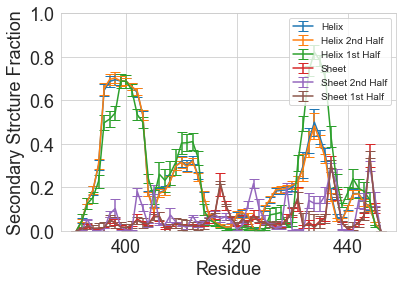

In [10]:
trjH1 = md.load(rep0, top=pdb,stride=1)
H1=top.select("resid 1 to 56")
trjH1.restrict_atoms(H1)
trjH1.center_coordinates()
frames=trjH1.n_frames
half=int(np.floor(frames/2))

h_res=[]
for res in trjH1.topology.residues: h_res.append(res.resSeq)
h_residues=len(set(h_res))
residue_offset=390
hres_renum=np.asarray(h_res)+residue_offset


frames=trj.n_frames
half=int(np.floor(frames/2))

dsspH1=md.compute_dssp(trjH1, simplified=True)
dsspH1_h2=md.compute_dssp(trjH1[half:-1], simplified=True)
dsspH1_h1=md.compute_dssp(trjH1[0:half], simplified=True)

H1_H,H1_E=dssp_convert(dsspH1)
H1_H_h2,H1_E_h2=dssp_convert(dsspH1_h2)
H1_H_h1,H1_E_h1=dssp_convert(dsspH1_h1)

plt.errorbar(hres_renum,H1_H[:,0],yerr=H1_H[:,1], capsize=5,label='Helix')
plt.errorbar(hres_renum,H1_H_h2[:,0],yerr=H1_H_h2[:,1], capsize=5,label='Helix 2nd Half')
plt.errorbar(hres_renum,H1_H_h1[:,0],yerr=H1_H_h1[:,1], capsize=5,label='Helix 1st Half')
plt.errorbar(hres_renum,H1_E[:,0],yerr=H1_E[:,1], capsize=5,label='Sheet')
plt.errorbar(hres_renum,H1_E_h1[:,0],yerr=H1_E_h1[:,1], capsize=5,label='Sheet 2nd Half')
plt.errorbar(hres_renum,H1_E_h2[:,0],yerr=H1_H_h2[:,1], capsize=5,label='Sheet 1st Half')

plt.ylim(0,1.0)
plt.legend(loc="upper right")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
np.savetxt(outdir+'Hprop.err.dat',np.column_stack((hres_renum,H1_H[:,0],H1_H[:,1])))
np.savetxt(outdir+'Eprop.err.dat',np.column_stack((hres_renum,H1_E[:,0],H1_E[:,1])))

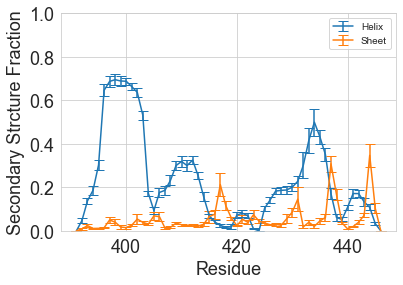

In [11]:
plt.errorbar(hres_renum,H1_H[:,0],yerr=H1_H[:,1], capsize=5,label='Helix')
plt.errorbar(hres_renum,H1_E[:,0],yerr=H1_E[:,1], capsize=5,label='Sheet')

plt.ylim(0,1.0)
plt.legend(loc="upper right")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)

In [12]:
dsspH=np.copy(dsspH1)
dsspH[dsspH=='H']=1                                                                                      
dsspH[dsspH=='E']=0                                                                                      
dsspH[dsspH=='C']=0                                                                                      
dsspH[dsspH=='NA']=0 
dsspH=dsspH.astype(int)
TotalH=np.sum(dsspH,axis=1) 
np.shape(dsspH1)
TotalH
print("Average Helical Residues:%6.3lf"%(np.average(TotalH)),"+_%6.3lf"%((block(TotalH)**.5)))
print("Average Fraction Helix:%6.3lf"%(np.average(TotalH)/56.0),"+_%6.3lf"%((block(TotalH)**.5)/56.0))


Average Helical Residues:13.062 +_ 0.364
Average Fraction Helix: 0.233 +_ 0.006


In [13]:
#Compute Phi and Psi
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
phi_label=[]
for i_phi in range(0, indices_phi.shape[0]):
      resindex=trj.topology.atom(indices_phi[i_phi][3]).residue.resSeq
      phi_label.append(resindex)
phi_label=np.array(phi_label)
psi_label=[]
for i_psi in range(0, indices_psi.shape[0]):
      resindex=trj.topology.atom(indices_psi[i_psi][3]).residue.resSeq
      psi_label.append(resindex)
psi_label=np.array(psi_label)
phipsi=[]
for i in range(0,len(psi_label)-1):
  current_phipsi=np.column_stack((phis[:,i+1],psis[:,i]))
  phipsi.append(current_phipsi)
phipsi_array=np.array(phipsi)

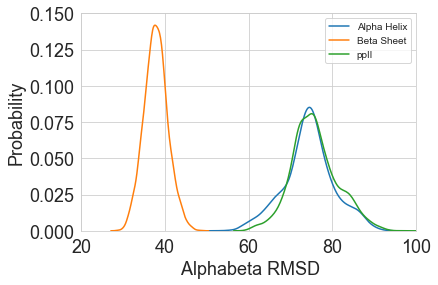

<Figure size 432x288 with 0 Axes>

In [14]:
def alphabeta_rmsd(phi,psi,phi_ref,psi_ref):
 alphabetarmsd=np.sum(0.5*(1+np.cos(psi-psi_ref)),axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)),axis=1)
 return alphabetarmsd 

#Phi_all=np.loadtxt(phipsi_dir+'/Phi.dat')[0:-1]
#Psi_all=np.loadtxt(phipsi_dir+'/Psi.dat')[0:-1]
Phi_all=phis
Psi_all=psis
alphabeta_alpharight=alphabeta_rmsd(Phi_all,Psi_all,-1.05,-0.79)
alphabeta_betasheet=alphabeta_rmsd(Phi_all,Psi_all,2.36,-2.36)
alphabeta_ppII=alphabeta_rmsd(Phi_all,Psi_all,-1.31,2.71)

#sns.set(style='whitegrid')
sns.kdeplot(data=alphabeta_alpharight,label='Alpha Helix')
sns.kdeplot(data=alphabeta_betasheet,label='Beta Sheet')
sns.kdeplot(data=alphabeta_ppII,label='ppII')

plt.xlabel(' Alphabeta RMSD',fontsize=18)
plt.xlim(20,100)
plt.ylim(0,0.15)

plt.ylabel('Probability',fontsize=18)
plt.legend(loc='upper right')
plt.tick_params(labelsize=18)

plt.show()
plt.savefig(outdir+'Alphabeta.histogram.png')

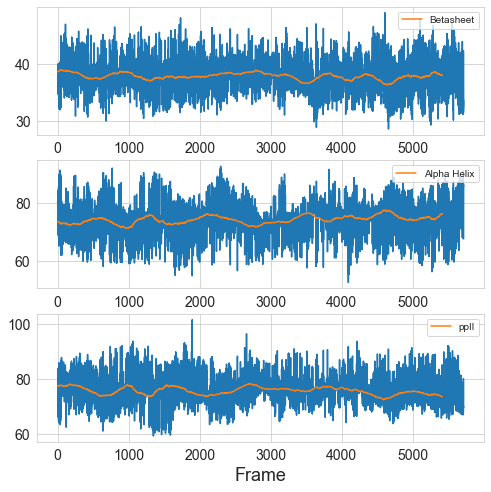

In [15]:
fig, ax = plt.subplots(3, figsize=((8,8)))
N=300
ax[0].plot(alphabeta_betasheet)
ax[0].plot(np.convolve(alphabeta_betasheet,np.ones(N)/N,mode='valid'),label='Betasheet')
ax[0].legend(loc='upper right')

ax[1].plot(alphabeta_alpharight)
ax[1].plot(np.convolve(alphabeta_alpharight,np.ones(N)/N,mode='valid'),label='Alpha Helix')
ax[1].legend(loc='upper right')

ax[2].plot(alphabeta_ppII)
ax[2].plot(np.convolve(alphabeta_ppII,np.ones(N)/N,mode='valid'),label='ppII')
ax[2].legend(loc='upper right')

ax[0].tick_params(labelsize=14)
ax[1].tick_params(labelsize=14)
ax[2].tick_params(labelsize=14)

plt.xlabel('Frame', size=18)
plt.savefig(outdir+'Alphabeta.timecourse.png')

CA Radius of Gyration: 1.255 +_ 0.010
1st Half CA Radius of Gyration: 1.252 +_ 0.008
2nd Half CA Radius of Gyration: 1.258 +_ 0.018


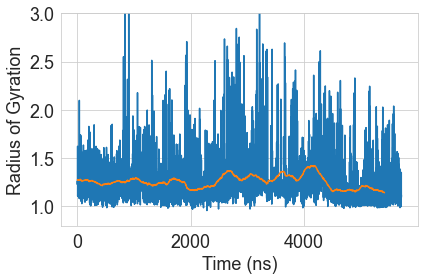

In [16]:
mass=[]
for at in trj.topology.atoms:
    mass.append(at.element.mass)
mass_CA = len(mass)*[0.0]
# put the CA entries equal to 1.0
for i in trj.topology.select("name CA"): mass_CA[i]=1.0
# calculate CA radius of gyration
rg_CA=md.compute_rg(trj, masses=np.array(mass_CA))
#SE_rg=(block(rg_all))**.5
#np.savetxt(outdir+"/Rgyr-CA.dat", rg_CA, header="Rgyr-CA", fmt='%.4lf')
#np.savetxt(outdir+"/Rgyr-CA.ave.dat", np.column_stack([np.average(rg_CA),SE_rg]),  fmt='%.4lf')
plt.clf()
plt.plot(rg_CA)
plt.plot(np.convolve(rg_CA,np.ones(N)/N,mode='valid'))
plt.xlabel('Time (ns)', size=18)
plt.ylabel('Radius of Gyration', size=18)
plt.ylim(0.8,3.0)
plt.tick_params(labelsize=18)
plt.tight_layout()
print("CA Radius of Gyration:%6.3lf"%np.average(rg_CA),"+_%6.3lf"%block(rg_CA)**.5)
print("1st Half CA Radius of Gyration:%6.3lf"%np.average(rg_CA[0:half]),"+_%6.3lf"%block(rg_CA[0:half])**.5)
print("2nd Half CA Radius of Gyration:%6.3lf"%np.average(rg_CA[half:-1]),"+_%6.3lf"%block(rg_CA[half:-1])**.5)

plt.savefig(outdir+'rg.pdf')
np.savetxt(outdir+'rg.dat',rg_CA)

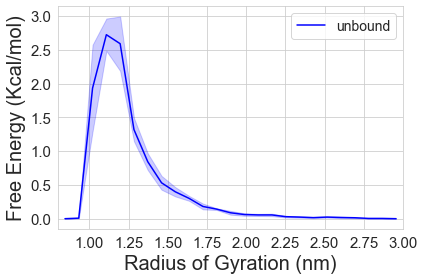

In [17]:
Rg_unbound, edges,u_err = histo_blockerror(rg_CA, 0.8, 3.0, 25,5)

plt.plot(edges, Rg_unbound,c='blue',label='unbound')
plt.fill_between(edges, Rg_unbound-u_err, Rg_unbound+u_err, color='blue', alpha=0.2)

#plt.ylim(0, 1)
plt.xlim(0.8, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()

/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:66: RuntimeWarning: invalid value encountered in true_divide
  ferr = -(0.001987*T)*(error / average)


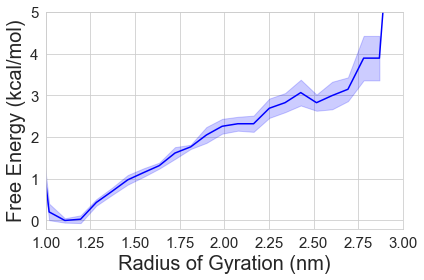

In [18]:
dG,bin_centers,ferr=free_energy_1D_blockerror(rg_CA, 300, 0.8, 3.0,25,5)
sns.lineplot(x=bin_centers,y=dG,color='blue')
plt.fill_between(bin_centers, dG-ferr, dG+ferr, color='blue', alpha=0.2)
plt.ylim(-0.2, 5)
plt.xlim(1.0, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
np.savetxt(outdir+'rg.dG.err.dat',np.column_stack((bin_centers, dG,ferr)))
plt.tight_layout()
plt.savefig('%s/Rg.dG.pdf'%outdir)
plt.show()

/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:66: RuntimeWarning: invalid value encountered in true_divide
  ferr = -(0.001987*T)*(error / average)


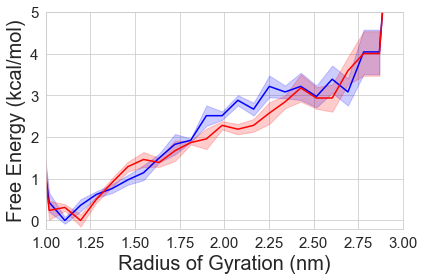

In [19]:
#[0:half],[half:-1]
dG1,bin_centers,ferr=free_energy_1D_blockerror(rg_CA[0:half], 300, 0.8, 3.0,25,5)
dG2,bin_centers,ferr=free_energy_1D_blockerror(rg_CA[half:-1], 300, 0.8, 3.0,25,5)
sns.lineplot(x=bin_centers,y=dG1,color='blue')
sns.lineplot(x=bin_centers,y=dG2,color='red')

plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color='blue', alpha=0.2)
plt.fill_between(bin_centers, dG2-ferr, dG2+ferr, color='red', alpha=0.2)

plt.ylim(-0.2, 5)
plt.xlim(1.0, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
#np.savetxt(outdir+'rg.dG.err.dat',np.column_stack((bin_centers, dG,ferr)))
plt.tight_layout()
plt.savefig('%s/Rg.dG.splithalfs.pdf'%outdir)
plt.show()

Number of residues: 58

AlphaRMSD: 6.511 +_ 0.153


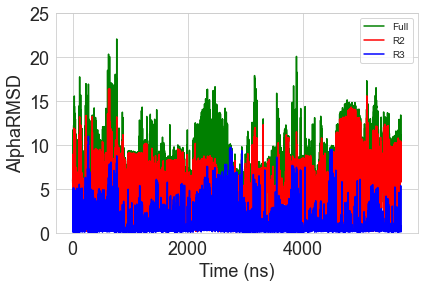

In [20]:
helix = md.load_pdb(helixpdb)
helix
top_helix = helix.topology
backbone_helix=top_helix.select("name CA")
backbone=top.select("name CA")

sel1=top_helix.select("name CA and residue 1 to 25")
sel2=top_helix.select("name CA and residue 36 to 56")

print("Number of residues: %d\n" % len(set(nres)))
RMS_start=1
RMS_stop=51
RMS=[]
for i in range(RMS_start,RMS_stop):
    #print(i,i+6)
    sel=top_helix.select("residue %s to %s and backbone" % (i,i+6))
    #print(sel)
    rmsd = md.rmsd(trj,helix,atom_indices=sel)
    RMS.append(rmsd)
RMS=np.asarray(RMS)
RMS

Sa_sum=np.zeros((trj.n_frames))
Sa=(1.0-(RMS/0.10)**8)/(1-(RMS/0.10)**12)
#Sa+=(1.0-(r/0.80)**8)/(1-(r/0.80)**12)
Sa_ave=np.average(Sa,axis=1)
Sa_total=np.sum(Sa,axis=0)
Sa_R2=np.sum(Sa[0:25],axis=0)
Sa_R3=np.sum(Sa[36:56],axis=0)

print("AlphaRMSD:%6.3lf"%np.average(Sa_total),"+_%6.3lf"%block(Sa_total)**.5)

#plt.plot(Sa_total)
#plt.plot(Sa_R2)
N=300
plt.plot(Sa_total,label='Full',c='g')
plt.plot(Sa_R2,label='R2',c='r')
plt.plot(Sa_R3,label='R3',c='b')
plt.legend()
plt.xlabel('Time (ns)', size=18)
plt.ylabel('AlphaRMSD', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.ylim(0,25)
plt.savefig(outdir+'Sa.timecourse.png')
np.savetxt(outdir+'Sa_total.dat',Sa_total)
np.savetxt(outdir+'Sa_total.R2.dat',Sa_R2)
np.savetxt(outdir+'Sa_total.R3.dat',Sa_R3)


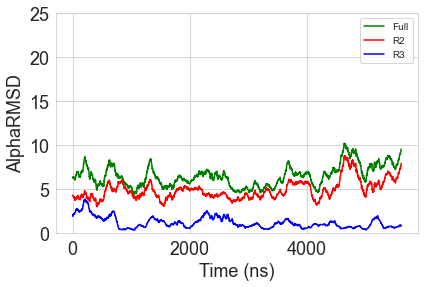

In [21]:
N=100
plt.plot(np.convolve(Sa_total,np.ones(N)/N,mode='valid'),label='Full',c='g')
plt.plot(np.convolve(Sa_R2,np.ones(N)/N,mode='valid'),label='R2',c='r')
plt.plot(np.convolve(Sa_R3,np.ones(N)/N,mode='valid'),label='R3',c='b')
plt.legend()
plt.xlabel('Time (ns)', size=18)
plt.ylabel('AlphaRMSD', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.ylim(0,25)
plt.savefig(outdir+'Sa.timecourse.smooth.png')

/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:66: RuntimeWarning: invalid value encountered in true_divide
  ferr = -(0.001987*T)*(error / average)


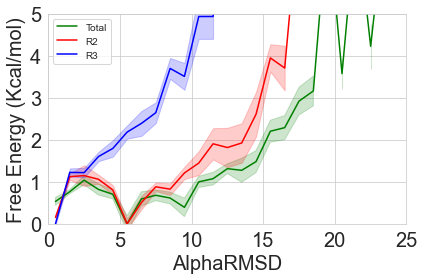

In [22]:
Sa_dg, edges,Sa_err = free_energy_1D_blockerror(Sa_total, 300, 0, 25, 25,5)
Sa2_dg, edges,Sa2_err = free_energy_1D_blockerror(Sa_R2, 300, 0, 25, 25,5)
Sa3_dg, edges,Sa3_err = free_energy_1D_blockerror(Sa_R3, 300, 0, 25, 25,5)

plt.clf()
plt.plot(edges, Sa_dg, c='g',label='Total')
plt.plot(edges, Sa2_dg,c='r',label='R2')
plt.plot(edges, Sa3_dg,c='b',label='R3')
plt.fill_between(edges, Sa_dg-Sa_err, Sa_dg+Sa_err, color='g', alpha=0.2)
plt.fill_between(edges, Sa2_dg-Sa2_err, Sa2_dg+Sa2_err, color='r', alpha=0.2)
plt.fill_between(edges, Sa3_dg-Sa3_err, Sa3_dg+Sa3_err, color='b', alpha=0.2)

plt.legend()

plt.ylim(0, 5)
plt.xlim(0, 25)
plt.xlabel('AlphaRMSD', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='20')
plt.yticks(size='20')
plt.tight_layout()
np.savetxt(outdir+'Sa_dg.dat',np.column_stack((edges, Sa_dg,Sa_err)))
np.savetxt(outdir+'Sa.R2dg.dat',np.column_stack((edges, Sa2_dg,Sa2_err)))
np.savetxt(outdir+'Sa.R3.dg.dat',np.column_stack((edges, Sa3_dg,Sa3_err)))
plt.savefig('%s/Sa.dG.png'%outdir)

In [23]:
rg_v_Sa=np.column_stack((rg_CA,Sa_total))
#print(len(rg_v_Sa_bound),rg_v_Sa_bound)
rg_cutoff=1.3
collapsed=np.where(rg_v_Sa[:,0]<rg_cutoff)[0]
#print(len(collapsed),collapsed)
#print(rg_v_Sa_bound[collapsed])
Sa_cutoff=6.0
helical=np.where(rg_v_Sa[:,1]>Sa_cutoff)[0]
#print(len(helical),helical)
#print(rg_v_Sa_bound[helical])
glob_index=np.intersect1d(collapsed,helical)
#print(len(glob_index),glob_index)
rg_v_Sa[glob_index]
globule_pop=len(glob_index)/len(rg_v_Sa)
print("Ensemble Globule Pop:",globule_pop,"Non Globule:",1-globule_pop)
T=300
glob_rg,glob_rg_be=get_blockerror_pyblock(rg_v_Sa[glob_index][:,0])
rg,rg_be=get_blockerror_pyblock(rg_v_Sa[:,0])
print("Rg:",rg,"+_",rg_be)
print("Globule Rg:",glob_rg,"+_",glob_rg_be)

T=300
print("Free Energy Globule:",-(0.001987*T)*np.log(globule_pop))
print("Free Energy Non-Globule:",-(0.001987*T)*np.log(1-globule_pop))
print("Free Energy Difference:",-(0.001987*T)*np.log(globule_pop/(1-globule_pop)))


glob_binary=np.zeros(len(rg_v_Sa))
glob_binary[glob_index]=1
glob_frac=len(glob_index)/len(glob_binary)
glob_boundfrac,glob_boundfrac_be=get_blockerror_pyblock(glob_binary)
print("Globule Fraction:",glob_boundfrac,"+_",glob_boundfrac_be)
glob_upper=glob_boundfrac+glob_boundfrac_be
non_glob=1-glob_boundfrac
non_glob_upper=1-(glob_boundfrac-glob_boundfrac_be)
print("Non Globule Fraction:",1-glob_boundfrac,"+_",glob_boundfrac_be)
dG_diff=-(0.001987*T)*np.log(globule_pop/(1-globule_pop))
dG_diff_upper=-(0.001987*T)*np.log((globule_pop+glob_boundfrac_be)/(1-globule_pop-glob_boundfrac_be))
print("Free Energy Difference:",dG_diff,"+_",dG_diff-dG_diff_upper)

Ensemble Globule Pop: 0.4040244969378828 Non Globule: 0.5959755030621172
Rg: 1.254771117377348 +_ 0.011322340800007342
Globule Rg: 1.1136439854581313 +_ 0.011099815589554418
Free Energy Globule: 0.5402333690338391
Free Energy Non-Globule: 0.308514961715242
Free Energy Difference: 0.23171840731859716
Globule Fraction: 0.4040244969378828 +_ 0.05422725922074863
Non Globule Fraction: 0.5959755030621172 +_ 0.05422725922074863
Free Energy Difference: 0.23171840731859716 +_ 0.13194159192389715


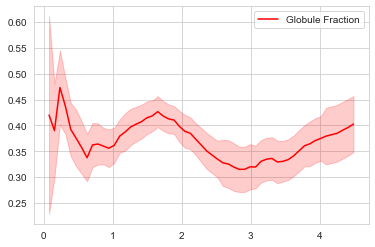

In [24]:
stride=100
be_by_frame=[]
ge_by_frame=[]
boundfrac_by_frame=[]
globfrac_by_frame=[]
bg_pop=[]
bg_pop2=[]
bge_by_frame=[]
time=np.linspace(0,4.5,len(glob_binary))
t=[]


for i in range(stride,len(glob_binary),stride):
    g_Data=np.asarray(glob_binary[0:i])
    frames=len(g_Data)
    gframes=np.where(g_Data==1)[0]
    gf,ge=get_blockerror_pyblock_nanskip(g_Data)
    globfrac_by_frame.append(gf)
    ge_by_frame.append(ge)
    t.append(time[i])


plt.plot(t,globfrac_by_frame,label='Globule Fraction',color='red')
plt.fill_between(t, np.asarray(globfrac_by_frame)+np.asarray(ge_by_frame), np.asarray(globfrac_by_frame)-np.asarray(ge_by_frame), color='red', alpha=0.2)
plt.legend(loc='upper right')

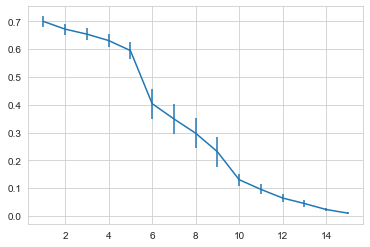

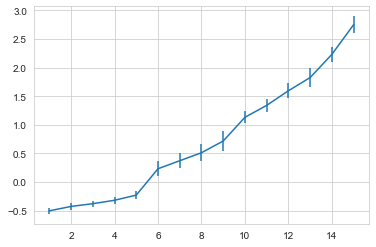

In [25]:
Sa_cut=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
glob_pops=[]
glob_errs=[]
glob_dGs=[]
glob_dGs_err=[]

rg_v_Sa=np.column_stack((rg_CA,Sa_total))
rg_cutoff=1.3
collapsed=np.where(rg_v_Sa[:,0]<rg_cutoff)[0]

for i in Sa_cut:
 Sa_cutoff=i
 helical=np.where(rg_v_Sa[:,1]>Sa_cutoff)[0]
 glob_index=np.intersect1d(collapsed,helical)
 globule_pop=len(glob_index)/len(rg_v_Sa)
 T=300
 glob_binary=np.zeros(len(rg_v_Sa))
 glob_binary[glob_index]=1
 glob_frac=len(glob_index)/len(glob_binary)
 glob_boundfrac,glob_boundfrac_be=get_blockerror_pyblock(glob_binary)
 glob_upper=glob_boundfrac+glob_boundfrac_be
 non_glob=1-glob_boundfrac
 non_glob_upper=1-(glob_boundfrac-glob_boundfrac_be)
 dG_diff=-(0.001987*T)*np.log(globule_pop/(1-globule_pop))
 dG_diff_upper=-(0.001987*T)*np.log((globule_pop+glob_boundfrac_be)/(1-globule_pop-glob_boundfrac_be))
 glob_pops.append(globule_pop)
 glob_errs.append(glob_boundfrac_be)
 glob_dGs.append(dG_diff)
 glob_dGs_err.append(dG_diff-dG_diff_upper)
    
plt.errorbar(Sa_cut,glob_pops,yerr=glob_errs)
plt.show()
plt.clf()
plt.errorbar(Sa_cut,glob_dGs,yerr=glob_dGs_err)
plt.show()

np.savetxt(outdir+'Pop.vs.Sacut.dat',np.column_stack((Sa_cut,glob_pops,glob_errs)))
np.savetxt(outdir+'dGglob.vs.Sacut.dat',np.column_stack((Sa_cut,glob_dGs,glob_dGs_err)))

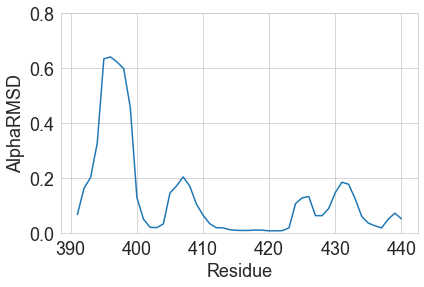

In [26]:
plt.plot(prot_res_renum[1:51],Sa_ave)
plt.xlabel('Residue', size=18)
plt.ylabel('AlphaRMSD', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.ylim(0,0.8)
plt.savefig('%s/Sa.ave.png'%outdir)

In [27]:
contact_maps = []
contact_distances = []
for i in range(1,57):
    contact_map = []
    contact_distance = []
    for j in range(1,57):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj,[[i,j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 1.2, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

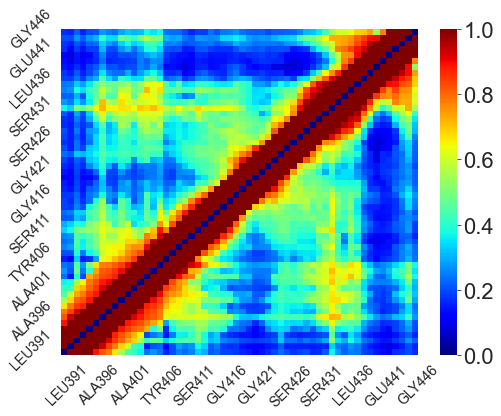

In [28]:
contact_map = final_map
sequence = ['LEU391', '', '', '', '', 'ALA396', '', '', '', '', 'ALA401', '', '', '', '', 'TYR406', '', '', '', '', 'SER411', '', '', '', '', 'GLY416',
            '', '', '', '', 'GLY421', '', '', '', '', 'SER426', '', '', '', '', 'SER431', '', '', '', '', 'LEU436', '', '', '', '', 'GLU441', '', '', '', '', 'GLY446']

# Make distance map
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
im = sns.heatmap(contact_map, cmap = 'jet', ax = ax)
ax.grid(which='both', alpha=0.5)
plt.xticks(range(1,57), sequence, rotation=45, size=14)
plt.yticks(range(1, 57), sequence, rotation=45, size=14)
cbar = im.collections[0].colorbar
# cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22)
ax.invert_yaxis()


np.savetxt(outdir+'contactmap.dat',final_map)
plt.savefig(outdir+'contact_map.png')
plt.savefig(outdir+'contact_map.pdf')
plt.show()


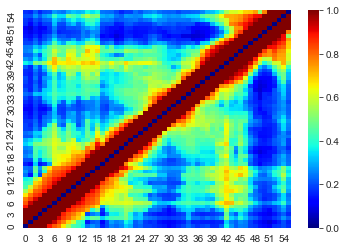

In [29]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)


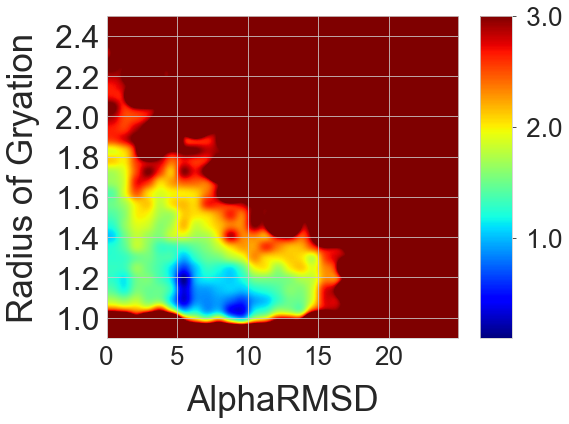

In [30]:
a,xedges,yedges=np.histogram2d(rg_CA,Sa_total,30,[[0.9,2.5],[0,25.0]],normed=True,weights=None)
a=np.log(np.flipud(a)+.000001)
T=300
a=-(0.001987*T)*a

fig=plt.figure(figsize=(8,6))
im=plt.imshow(a, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
cbar_ticks=[0,1,2,3,4,5]
plt.xlim(0,24.9)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Radius of Gryation",size=35,labelpad=15)
plt.xlabel("AlphaRMSD",size=35,labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1,vmax=3.0)
plt.yticks(size='26')


plt.tight_layout()
np.savetxt(outdir+'Apo.Rg_v_Sa.dG.dat',a)
plt.savefig(outdir+'Apo.Rg_v_Sa.dG.pdf')


<Figure size 432x288 with 0 Axes>

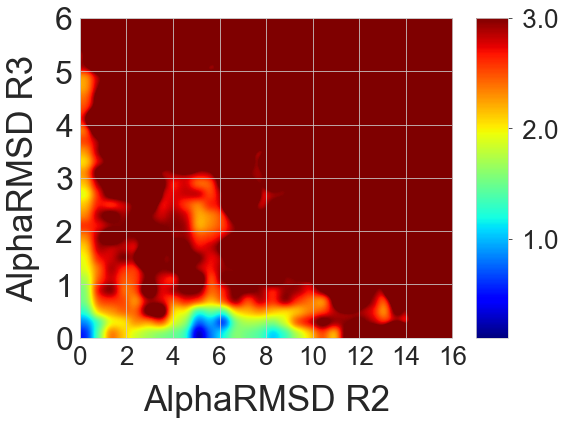

In [31]:
dG, xedges, yedges = free_energy(Sa_R3,Sa_R2, 300, 0, 6.0, 0, 16.0)

#a,xedges,yedges=np.histogram2d(Sa_total_H2,Sa_total_H1,35,[[0,3.5],[0,12]],normed=True,weights=None)
#a=np.log(np.flipud(a)+.000001)
#T=300
#a=-(0.001987*T)*a

plt.clf()
fig=plt.figure(figsize=(8,6))
im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
cbar_ticks=[0,1,2,3]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("AlphaRMSD R3",size=35,labelpad=15)
plt.xlabel("AlphaRMSD R2",size=35,labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1,vmax=3.0)
plt.yticks(size='26')

plt.tight_layout()
np.savetxt(outdir+'SaR3_v_SaR2.dg.dat',dG)
plt.savefig(outdir+'R2_v_R3.pdf')

In [33]:
distances = np.empty((trj.n_frames, trj.n_frames))
for i in range(trj.n_frames):
    distances[i] = md.rmsd(trj, trj, i)
print('Max pairwise rmsd: %f nm' % np.max(distances))

Max pairwise rmsd: 3.464866 nm


(5715, 5715)

In [39]:
distances

array([[0.000, 0.344, 0.345, ..., 1.176, 1.095, 1.082],
       [0.344, 0.000, 0.270, ..., 1.206, 1.074, 1.054],
       [0.345, 0.270, 0.000, ..., 1.177, 1.090, 1.061],
       ...,
       [1.176, 1.206, 1.177, ..., 0.000, 1.156, 1.172],
       [1.095, 1.074, 1.090, ..., 1.156, 0.000, 0.215],
       [1.082, 1.054, 1.061, ..., 1.172, 0.215, 0.000]])

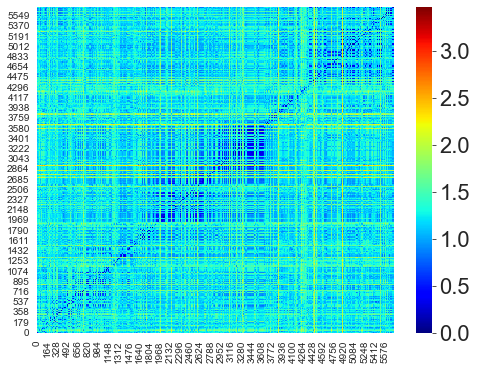

In [40]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
im = sns.heatmap(distances, cmap = 'jet', ax = ax)
ax.grid(which='both', alpha=0.5)
#plt.xticks(range(1,57), sequence, rotation=45, size=14)
#plt.yticks(range(1, 57), sequence, rotation=45, size=14)
cbar = im.collections[0].colorbar
# cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22)
ax.invert_yaxis()

In [69]:
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage


In [45]:
A=distances - distances.T
np.max(A)
reduced_distances = squareform(distances, checks=False)


0.00012874603271484375

In [71]:
linkage = scipy.cluster.hierarchy.linkage(reduced_distances, method='average')

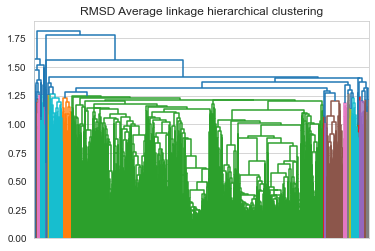

In [72]:
plt.title('RMSD Average linkage hierarchical clustering')
_ = scipy.cluster.hierarchy.dendrogram(linkage, no_labels=True, count_sort='descendent')

In [73]:
np.shape(linkage)

(5714, 4)

In [74]:
linkage

array([[5339.000, 5376.000, 0.108, 2.000],
       [5317.000, 5318.000, 0.109, 2.000],
       [5364.000, 5386.000, 0.116, 2.000],
       ...,
       [2681.000, 11424.000, 1.570, 208.000],
       [1894.000, 11425.000, 1.780, 5507.000],
       [11426.000, 11427.000, 1.814, 5715.000]])

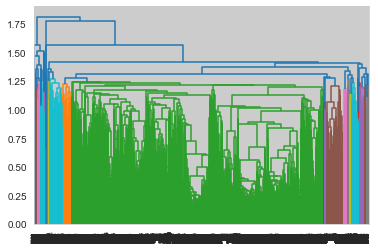

In [75]:
dn = dendrogram(linkage)

In [87]:
for key in dn:
    print(key)
    print((dn[key]))

icoord
[[15.0, 15.0, 25.0, 25.0], [35.0, 35.0, 45.0, 45.0], [20.0, 20.0, 40.0, 40.0], [85.0, 85.0, 95.0, 95.0], [75.0, 75.0, 90.0, 90.0], [115.0, 115.0, 125.0, 125.0], [105.0, 105.0, 120.0, 120.0], [82.5, 82.5, 112.5, 112.5], [65.0, 65.0, 97.5, 97.5], [55.0, 55.0, 81.25, 81.25], [30.0, 30.0, 68.125, 68.125], [155.0, 155.0, 165.0, 165.0], [185.0, 185.0, 195.0, 195.0], [175.0, 175.0, 190.0, 190.0], [160.0, 160.0, 182.5, 182.5], [215.0, 215.0, 225.0, 225.0], [205.0, 205.0, 220.0, 220.0], [245.0, 245.0, 255.0, 255.0], [235.0, 235.0, 250.0, 250.0], [212.5, 212.5, 242.5, 242.5], [171.25, 171.25, 227.5, 227.5], [145.0, 145.0, 199.375, 199.375], [135.0, 135.0, 172.1875, 172.1875], [49.0625, 49.0625, 153.59375, 153.59375], [265.0, 265.0, 275.0, 275.0], [295.0, 295.0, 305.0, 305.0], [285.0, 285.0, 300.0, 300.0], [270.0, 270.0, 292.5, 292.5], [325.0, 325.0, 335.0, 335.0], [315.0, 315.0, 330.0, 330.0], [355.0, 355.0, 365.0, 365.0], [345.0, 345.0, 360.0, 360.0], [385.0, 385.0, 395.0, 395.0], [375.0

In [111]:
cluster_list=dn['color_list']

In [112]:
np.shape(cluster_list)

(5714,)

In [118]:
def find_indices(list_to_check, item_to_find):
    array = np.array(list_to_check)
    indices = np.where(array == item_to_find)[0]
    return list(indices)

cdef={}
clusters = []
for x in cluster_list:
    if x not in clusters:
        clusters.append(x)
print(clusters)

for i in clusters:
 ind=find_indices(cluster_list, i)
 c_dict[i]=np.array(ind) 
    
for key in c_dict:
    print(len(c_dict[key]))

['C1', 'C2', 'C0', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
182
4326
36
37
153
367
105
95
51
362


/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]


/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)

/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]


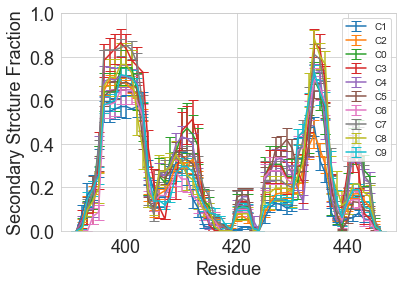

In [129]:
trjH1 = md.load(rep0, top=pdb,stride=10)
H1=top.select("resid 1 to 56")
trjH1.restrict_atoms(H1)
trjH1.center_coordinates()
frames=trjH1.n_frames
half=int(np.floor(frames/2))



h_res=[]
for res in trjH1.topology.residues: h_res.append(res.resSeq)
h_residues=len(set(h_res))
residue_offset=390
hres_renum=np.asarray(h_res)+residue_offset

dssp_dict={}
for key in c_dict:
   H1_H,H1_E=dssp_convert(dsspH1[c_dict[key]])
   plt.errorbar(hres_renum,H1_H[:,0],yerr=H1_H[:,1], capsize=5,label='%s'%key)
   #plt.errorbar(hres_renum,H1_E[:,0],yerr=H1_E[:,1], capsize=5,label='%s'%key)

    
    
#dsspH1=md.compute_dssp(trjH1, simplified=True)
#H1_H,H1_E=dssp_convert(dsspH1)
#plt.errorbar(hres_renum,H1_H[:,0],yerr=H1_H[:,1], capsize=5,label='Helix')
#plt.errorbar(hres_renum,H1_E[:,0],yerr=H1_E[:,1], capsize=5,label='Sheet')


plt.ylim(0,1.0)
plt.legend(loc="upper right")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
#np.savetxt(outdir+'Hprop.err.dat',np.column_stack((hres_renum,H1_H[:,0],H1_H[:,1])))
#np.savetxt(outdir+'Eprop.err.dat',np.column_stack((hres_renum,H1_E[:,0],H1_E[:,1])))

/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]


/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)

/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]


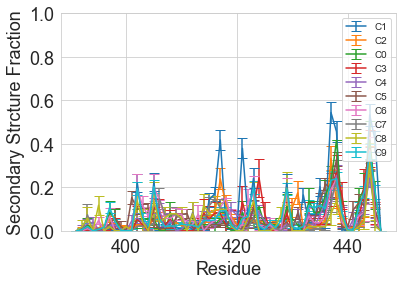

In [130]:
for key in c_dict:
   H1_H,H1_E=dssp_convert(dsspH1[c_dict[key]])
   #plt.errorbar(hres_renum,H1_H[:,0],yerr=H1_H[:,1], capsize=5,label='%s'%key)
   plt.errorbar(hres_renum,H1_E[:,0],yerr=H1_E[:,1], capsize=5,label='%s'%key)
plt.ylim(0,1.0)
plt.legend(loc="upper right")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)

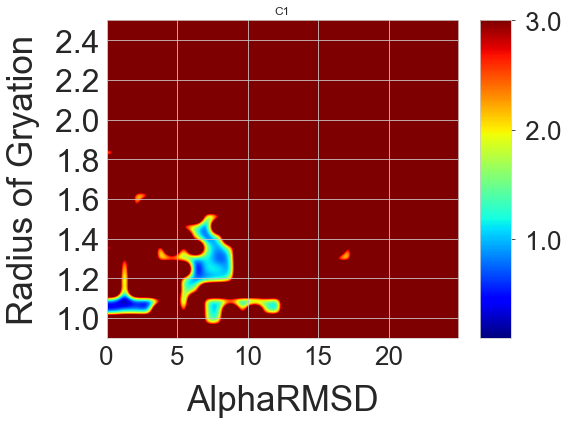

<Figure size 432x288 with 0 Axes>

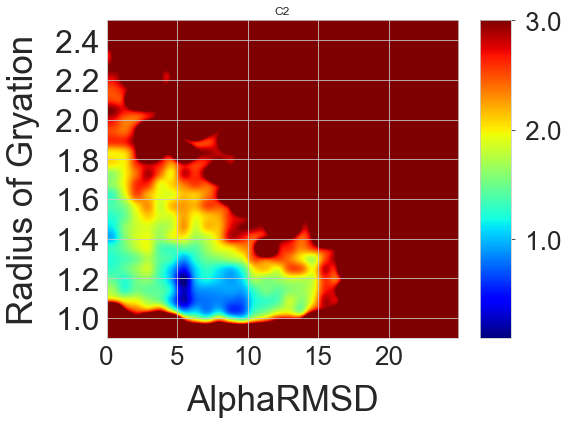

<Figure size 432x288 with 0 Axes>

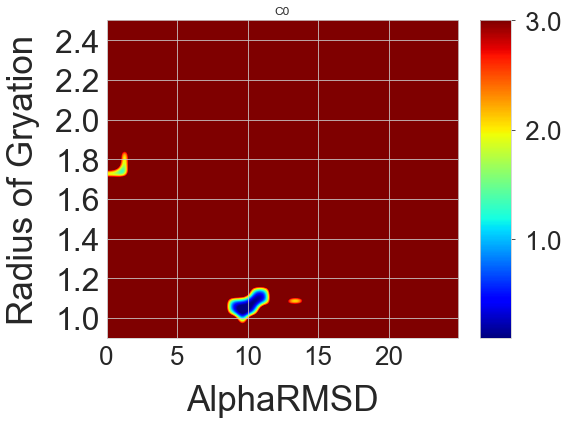

<Figure size 432x288 with 0 Axes>

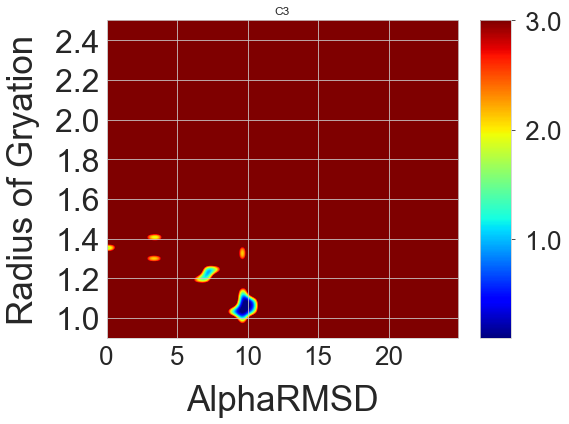

<Figure size 432x288 with 0 Axes>

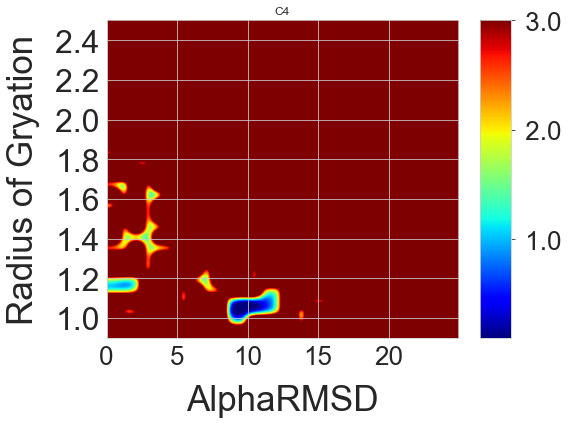

<Figure size 432x288 with 0 Axes>

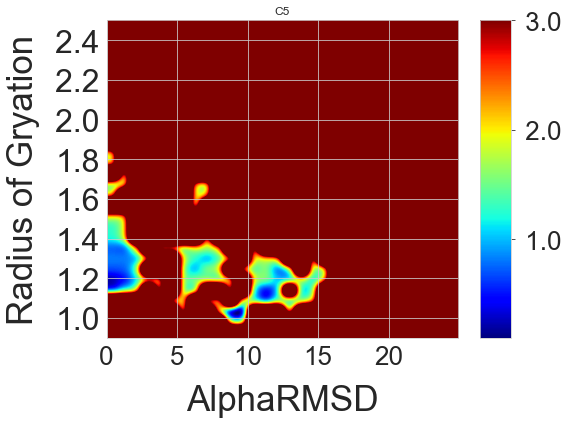

<Figure size 432x288 with 0 Axes>

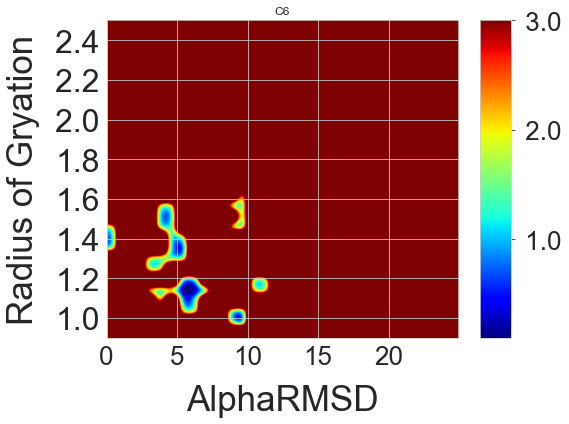

<Figure size 432x288 with 0 Axes>

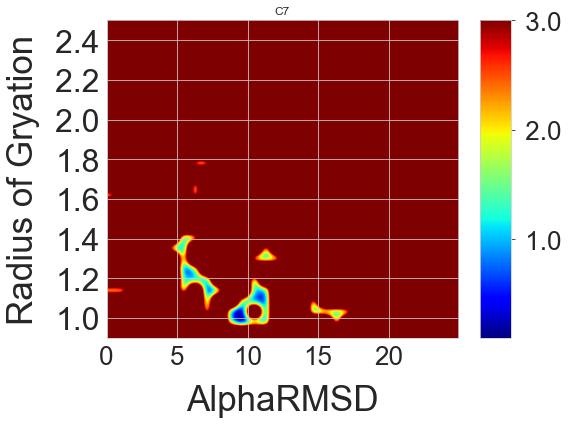

<Figure size 432x288 with 0 Axes>

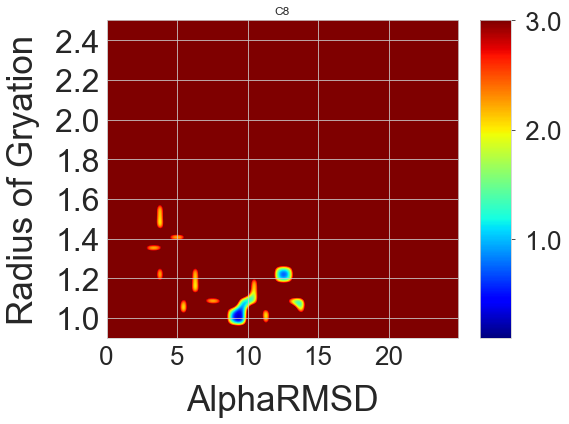

<Figure size 432x288 with 0 Axes>

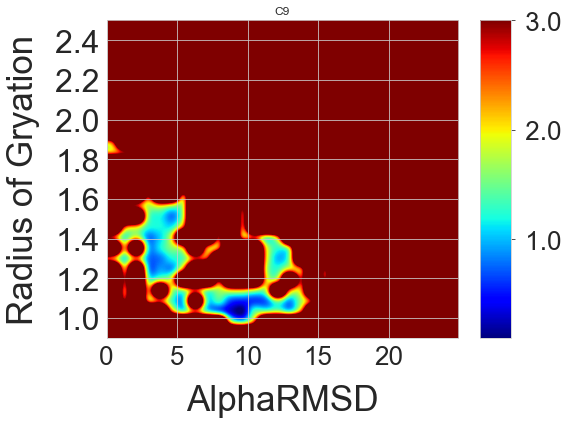

<Figure size 432x288 with 0 Axes>

In [134]:
for key in c_dict:
 frame_ind=c_dict[key]
 a,xedges,yedges=np.histogram2d(rg_CA[frame_ind],Sa_total[frame_ind],30,[[0.9,2.5],[0,25.0]],normed=True,weights=None)
 a=np.log(np.flipud(a)+.000001)
 T=300
 a=-(0.001987*T)*a

 fig=plt.figure(figsize=(8,6))
 im=plt.imshow(a, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()
 plt.xlim(0,24.9)  

 plt.ylabel("Radius of Gryation",size=35,labelpad=15)
 plt.xlabel("AlphaRMSD",size=35,labelpad=15)
 plt.xticks(fontsize=35)
 plt.yticks(fontsize=35)
 plt.xticks(size='26')
 plt.yticks(size='32')
 plt.title('%s'%key)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=3.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 plt.clf()   
#np.savetxt(outdir+'Rg_v_Sa.unbound.dG.dat',a)
#plt.savefig(outdir+'Rg_v_Sa.dG.unbound.pdf')

In [139]:
import sklearn.utils.validation as suv
distance_sym=suv.check_symmetric(distances, raise_exception=False)

/Users/paulrobustelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


In [141]:
suv.check_symmetric(distance_sym, raise_exception=True)

array([[0.000, 0.344, 0.345, ..., 1.176, 1.095, 1.082],
       [0.344, 0.000, 0.270, ..., 1.206, 1.074, 1.054],
       [0.345, 0.270, 0.000, ..., 1.177, 1.090, 1.061],
       ...,
       [1.176, 1.206, 1.177, ..., 0.000, 1.156, 1.172],
       [1.095, 1.074, 1.090, ..., 1.156, 0.000, 0.215],
       [1.082, 1.054, 1.061, ..., 1.172, 0.215, 0.000]])

In [142]:
from os.path import join
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Inputs for TSNE: provide distance matrix between all pairs of conformations. The RMSD.dat that I am using in the next line is the pairwise RMSD obtained from Gromacs in binary vector format.

#data = np.fromfile('rmsd.dat', np.float32)
#rmsd = data.reshape(int(np.sqrt(len(data))), int(np.sqrt(len(data)))) ### To reshape the vector to matrix

#distance_sym is the symmetric RMSD matrix 

##To make sure if the matrix is symmetric
import sklearn.utils.validation as suv
#suv.check_symmetric(distances, raise_exception=True)
#distance_sym=suv.check_symmetric(distances, raise_exception=False)

with open('status.txt', 'a') as f1:
     f1.write("\n")
     print('symmetry check completed', file=f1)

# Creating the TSNE object and projection
perplexityVals = range(100, 2100, 100)
for i in perplexityVals:
    tsneObject = TSNE(n_components=2, perplexity=i, early_exaggeration=10.0, learning_rate=100.0, n_iter=3500, n_iter_without_progress=300, min_grad_norm=1e-7, metric="precomputed", init='random', method='barnes_hut', angle=0.5) ### metric is precomputed RMSD distance. if you provide Raw coordinates, the TSNE will compute the distance by default with Euclidean metrics
    tsne = tsneObject.fit_transform(distance_sym)
    np.savetxt("tsnep{0}".format(i), tsne)

#Kmeans clustering
#range_n_clusters = [3,5,10, 15, 20]
range_n_clusters = [2, 4, 6, 8, 10, 12, 14, 16, 18]
perplexityVals = range(100, 2100, 100)
for perp in perplexityVals:
    tsne = np.loadtxt('tsnep'+str(perp))
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters).fit(tsne)
        np.savetxt('kmeans_'+str(n_clusters)+'clusters_centers_tsnep'+str(perp), kmeans.cluster_centers_, fmt='%1.3f')
        np.savetxt('kmeans_'+str(n_clusters)+'clusters_tsnep'+str(perp)+'.dat', kmeans.labels_, fmt='%1.1d')
#### Compute silhouette score based on low-dim and high-dim distances        
        silhouette_ld = silhouette_score(tsne, kmeans.labels_)
        silhouette_hd = metrics.silhouette_score(rmsd, kmeans.labels_, metric='precomputed')
        with open('silhouette.txt', 'a') as f:
            f.write("\n")
            print(perp, n_clusters, silhouette_ld, silhouette_hd, silhouette_ld*silhouette_hd, file =f)

##### plotting for the best cluster with highest silhouette score######      
s = np.loadtxt('silhouette.txt')
[bestP,bestK] = s[np.argmax(s[:,4]), 0], s[np.argmax(s[:,4]), 1]
besttsne = np.loadtxt('tsnep'+str(int(bestP)))
bestclust = np.loadtxt('kmeans_'+str(int(bestK))+'clusters_tsnep'+str(int(bestP))+'.dat')
plt.rc('font', family='sans-serif', weight='normal', size='14')
plt.rc('axes', linewidth=1.5)
cmap = cm.get_cmap('jet', bestK)
plt.scatter(besttsne[:,0], besttsne[:,1], c= bestclust.astype(float), s=50, alpha=0.5, cmap=cmap)
plt.savefig('tsnep'+str(int(bestP))+'_kmeans'+str(int(bestK))+'.png', dpi=600)

/Users/paulrobustelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/Users/paulrobustelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/Users/paulrobustelli/opt/anaconda3/

/Users/paulrobustelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/Users/paulrobustelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/Users/paulrobustelli/opt/anaconda3/

ValueError: Expected 2D array, got 1D array instead:
array=[0.326 0.322 0.339 ... 0.361 0.126 0.171].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [155]:
silhouette_ld

0.35983235750725506

perp: 100
n_clusters 2
Kmeans KMeans(n_clusters=2) [0 0 0 ... 0 0 0]
tsne shape: (5715, 2)
kmeans labels shape: (5715,)
0.3598513487008031
n_clusters 4
Kmeans KMeans(n_clusters=4) [2 2 2 ... 2 0 0]
tsne shape: (5715, 2)
kmeans labels shape: (5715,)
0.41844921060241563
n_clusters 6
Kmeans KMeans(n_clusters=6) [2 2 2 ... 2 0 0]
tsne shape: (5715, 2)
kmeans labels shape: (5715,)
0.434259001945271
n_clusters 8
Kmeans KMeans() [4 4 4 ... 4 0 0]
tsne shape: (5715, 2)
kmeans labels shape: (5715,)
0.45970711309203866
n_clusters 10
Kmeans KMeans(n_clusters=10) [2 2 2 ... 2 2 2]
tsne shape: (5715, 2)
kmeans labels shape: (5715,)
0.4583385962307921
n_clusters 12
Kmeans KMeans(n_clusters=12) [ 2  2  2 ...  2 11 11]
tsne shape: (5715, 2)
kmeans labels shape: (5715,)
0.4619191768004624
n_clusters 14
Kmeans KMeans(n_clusters=14) [ 1  1  1 ...  1 11 11]
tsne shape: (5715, 2)
kmeans labels shape: (5715,)
0.4616811339334727
n_clusters 16
Kmeans KMeans(n_clusters=16) [7 7 7 ... 7 8 8]
tsne shape: (5715, 

0.4281942676911499
perp: 800
n_clusters 2
Kmeans KMeans(n_clusters=2) [1 1 1 ... 1 1 1]
tsne shape: (5715, 2)
kmeans labels shape: (5715,)
0.42400959143330874
n_clusters 4
Kmeans KMeans(n_clusters=4) [1 1 1 ... 2 2 2]
tsne shape: (5715, 2)
kmeans labels shape: (5715,)
0.40158783916873975
n_clusters 6
Kmeans KMeans(n_clusters=6) [2 2 2 ... 1 5 5]
tsne shape: (5715, 2)
kmeans labels shape: (5715,)
0.3828714158603176
n_clusters 8
Kmeans KMeans() [0 0 0 ... 6 7 7]
tsne shape: (5715, 2)
kmeans labels shape: (5715,)
0.39189398639785883
n_clusters 10
Kmeans KMeans(n_clusters=10) [8 8 8 ... 8 4 4]
tsne shape: (5715, 2)
kmeans labels shape: (5715,)
0.4101942191464205
n_clusters 12
Kmeans KMeans(n_clusters=12) [ 0  0  0 ...  0 11 11]
tsne shape: (5715, 2)
kmeans labels shape: (5715,)
0.4154169280180208
n_clusters 14
Kmeans KMeans(n_clusters=14) [10 10 10 ... 10 13 13]
tsne shape: (5715, 2)
kmeans labels shape: (5715,)
0.41248978203122194
n_clusters 16
Kmeans KMeans(n_clusters=16) [15 15 15 ... 1

Kmeans KMeans(n_clusters=18) [15 15 15 ... 17  3  3]
tsne shape: (5715, 2)
kmeans labels shape: (5715,)
0.417518817007529
perp: 1500
n_clusters 2
Kmeans KMeans(n_clusters=2) [0 0 0 ... 0 0 0]
tsne shape: (5715, 2)
kmeans labels shape: (5715,)
0.392334249854728
n_clusters 4
Kmeans KMeans(n_clusters=4) [1 1 1 ... 1 3 3]
tsne shape: (5715, 2)
kmeans labels shape: (5715,)
0.3954071258720396
n_clusters 6
Kmeans KMeans(n_clusters=6) [5 5 5 ... 0 3 3]
tsne shape: (5715, 2)
kmeans labels shape: (5715,)
0.36908431583550105
n_clusters 8
Kmeans KMeans() [5 5 5 ... 5 4 4]
tsne shape: (5715, 2)
kmeans labels shape: (5715,)
0.3808330134488771
n_clusters 10
Kmeans KMeans(n_clusters=10) [9 9 9 ... 8 1 1]
tsne shape: (5715, 2)
kmeans labels shape: (5715,)
0.3949181066186426
n_clusters 12
Kmeans KMeans(n_clusters=12) [ 3  3  3 ... 11  7  7]
tsne shape: (5715, 2)
kmeans labels shape: (5715,)
0.4156482595631536
n_clusters 14
Kmeans KMeans(n_clusters=14) [ 2  2  2 ...  6 12 12]
tsne shape: (5715, 2)
kmeans

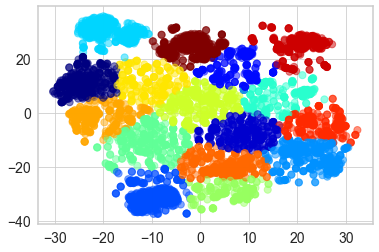

In [156]:
#Kmeans clustering
#range_n_clusters = [3,5,10, 15, 20]
range_n_clusters = [2, 4, 6, 8, 10, 12, 14, 16, 18]
perplexityVals = range(100, 2100, 100)
for perp in perplexityVals:
    print("perp:",perp)
    tsne = np.loadtxt('tsnep'+str(perp))
    for n_clusters in range_n_clusters:
        print("n_clusters",n_clusters)
        kmeans = KMeans(n_clusters=n_clusters).fit(tsne)
        np.savetxt('kmeans_'+str(n_clusters)+'clusters_centers_tsnep'+str(perp), kmeans.cluster_centers_, fmt='%1.3f')
        np.savetxt('kmeans_'+str(n_clusters)+'clusters_tsnep'+str(perp)+'.dat', kmeans.labels_, fmt='%1.1d')
        print("Kmeans",kmeans,kmeans.labels_)
#### Compute silhouette score based on low-dim and high-dim distances        
        print("tsne shape:",np.shape(tsne))
        print("kmeans labels shape:",np.shape(kmeans.labels_))
        silhouette_ld = silhouette_score(tsne, kmeans.labels_)
        print(silhouette_ld)
        silhouette_hd = metrics.silhouette_score(distance_sym, kmeans.labels_, metric='precomputed')
        with open('silhouette.txt', 'a') as f:
            f.write("\n")
            print(perp, n_clusters, silhouette_ld, silhouette_hd, silhouette_ld*silhouette_hd, file =f)

##### plotting for the best cluster with highest silhouette score######      
s = np.loadtxt('silhouette.txt')
[bestP,bestK] = s[np.argmax(s[:,4]), 0], s[np.argmax(s[:,4]), 1]
besttsne = np.loadtxt('tsnep'+str(int(bestP)))
bestclust = np.loadtxt('kmeans_'+str(int(bestK))+'clusters_tsnep'+str(int(bestP))+'.dat')
plt.rc('font', family='sans-serif', weight='normal', size='14')
plt.rc('axes', linewidth=1.5)
cmap = cm.get_cmap('jet', bestK)
plt.scatter(besttsne[:,0], besttsne[:,1], c= bestclust.astype(float), s=50, alpha=0.5, cmap=cmap)
plt.savefig('tsnep'+str(int(bestP))+'_kmeans'+str(int(bestK))+'.png', dpi=600)

[8.000 8.000 8.000 ... 12.000 13.000 13.000]


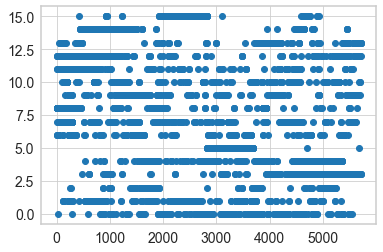

In [167]:
print(bestclust)
plt.plot(bestclust,marker='o',linewidth=0)

[300.0, 16.0]


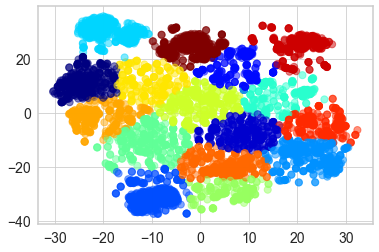

In [236]:
##### plotting for the best cluster with highest silhouette score######      
s = np.loadtxt('silhouette.txt')
[bestP,bestK] = s[np.argmax(s[:,4]), 0], s[np.argmax(s[:,4]), 1]
besttsne = np.loadtxt('tsnep'+str(int(bestP)))
bestclust = np.loadtxt('kmeans_'+str(int(bestK))+'clusters_tsnep'+str(int(bestP))+'.dat')
plt.rc('font', family='sans-serif', weight='normal', size='14')
plt.rc('axes', linewidth=1.5)
cmap = cm.get_cmap('jet', bestK)
plt.scatter(besttsne[:,0], besttsne[:,1], c= bestclust.astype(float), s=50, alpha=0.5, cmap=cmap)
plt.savefig('tsnep'+str(int(bestP))+'_kmeans'+str(int(bestK))+'.png', dpi=600)
print([bestP,bestK])

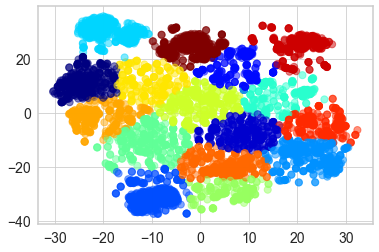

In [173]:
s = np.loadtxt('silhouette.txt')
[bestP,bestK] = s[np.argmax(s[:,4]), 0], s[np.argmax(s[:,4]), 1]
bestclust = np.loadtxt('kmeans_'+str(int(bestK))+'clusters_tsnep'+str(int(bestP))+'.dat')
plt.rc('font', family='sans-serif', weight='normal', size='14')
plt.rc('axes', linewidth=1.5)
cmap = cm.get_cmap('jet', bestK)
plt.scatter(besttsne[:,0], besttsne[:,1], c= bestclust.astype(float), s=50, alpha=0.5, cmap=cmap)
plt.savefig('tsnep'+str(int(bestP))+'_kmeans'+str(int(bestK))+'.png', dpi=600)

20

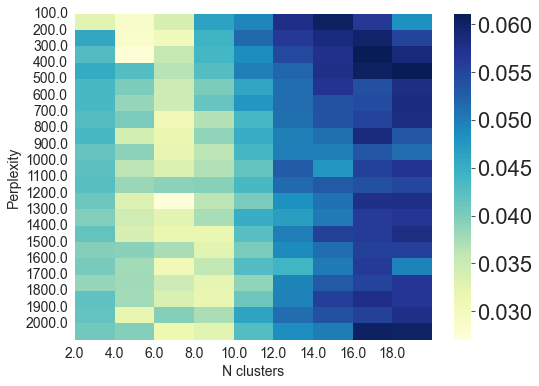

In [257]:
len(s[:,4])
n_cluster_columns=np.reshape(s[:,1], (20, 9))[0]
perp_columns=np.reshape(s[:,0], (20, 9))[:,0]
sil_score=np.reshape(s[:,4], (20, 9))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
im = sns.heatmap(sil_score, cmap = 'YlGnBu', ax = ax)
ax.grid(which='both', alpha=0.5)
#plt.xticks(range(1,57), sequence, rotation=45, size=14)
plt.yticks(range(0, 20), perp_columns, rotation=0, size=14)
plt.xticks(range(0,9), n_cluster_columns, rotation=0, size=14)
plt.xlabel("N clusters")
plt.ylabel("Perplexity")

#plt.yticks(range(1, 57), sequence, rotation=45, size=14)
cbar = im.collections[0].colorbar
# cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22)
#ax.invert_xaxis()
len(perp_columns)

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
im = sns.heatmap(distances, cmap = 'jet', ax = ax)
ax.grid(which='both', alpha=0.5)
#plt.xticks(range(1,57), sequence, rotation=45, size=14)
#plt.yticks(range(1, 57), sequence, rotation=45, size=14)
cbar = im.collections[0].colorbar
# cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22)
ax.invert_yaxis()

In [183]:
bestclust_int=bestclust.astype(int)

In [186]:
c_members = {i: np.where(bestclust_int == i)[0] for i in range(int(bestK))}
with open('c_members'+str(bestK)+'.txt', 'w') as f:
     print(c_members, file=f)

In [206]:
def find_indices(list_to_check, item_to_find):
    array = np.array(list_to_check)
    indices = np.where(array == item_to_find)[0]
    return list(indices)

cdef={}
clusters = []
for x in bestclust_int:
    if x not in clusters:
        clusters.append(x)
print(clusters)

c_dict={}
for i in clusters:
 ind=find_indices(bestclust_int, i)
 c_dict[i]=np.array(ind) 
    
for key in c_dict:
    print(len(c_dict[key]))

[8, 7, 6, 12, 11, 0, 13, 10, 1, 9, 2, 15, 14, 3, 4, 5]
206
349
239
408
311
325
312
220
360
395
282
498
357
510
450
493


/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]


/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)

/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]


/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
/var/folders/n6/2_qx6kgx25vcj876yc4xmmqw0000gp/T/ipykernel_25847/683657942.py:25: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]


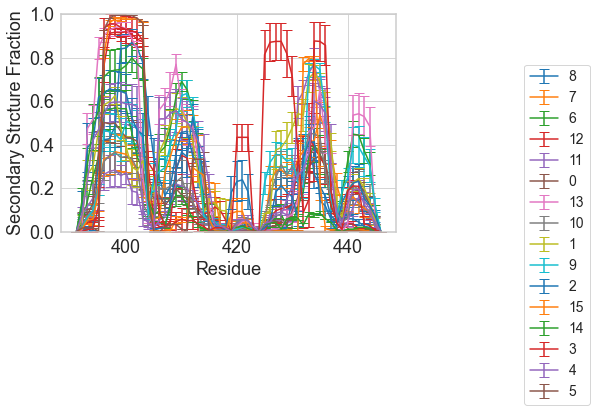

In [270]:
for key in c_dict:
   H1_H,H1_E=dssp_convert(dsspH1[c_dict[key]])
   #plt.errorbar(hres_renum,H1_H[:,0],yerr=H1_H[:,1], capsize=5,label='%s'%key)
   plt.errorbar(hres_renum,H1_H[:,0],yerr=H1_H[:,1], capsize=5,label='%s'%key)
plt.ylim(0,1.0)
plt.legend(loc="center right")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
plt.legend(loc='upper right', bbox_to_anchor=(1.6, 0.8), fontsize=14)


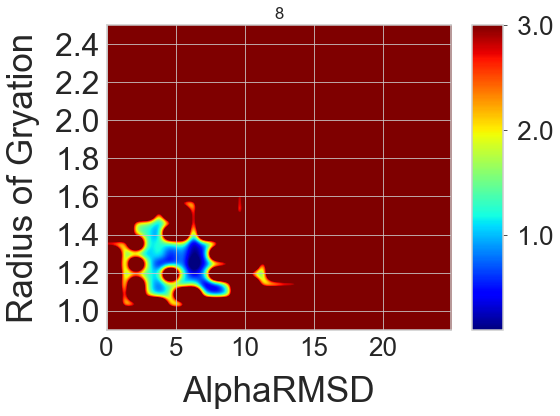

<Figure size 432x288 with 0 Axes>

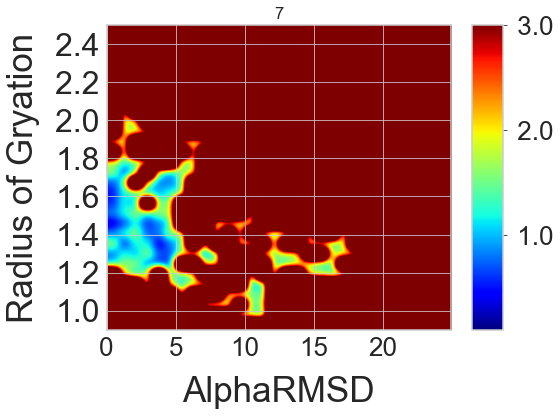

<Figure size 432x288 with 0 Axes>

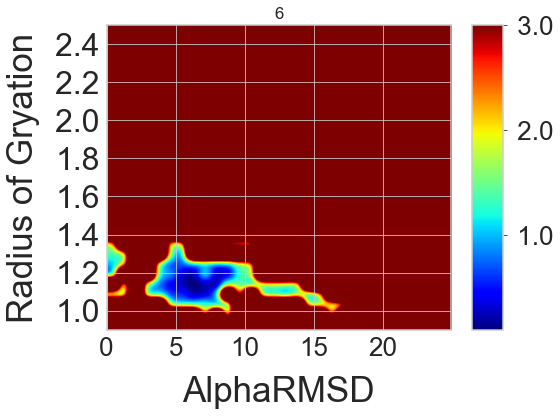

<Figure size 432x288 with 0 Axes>

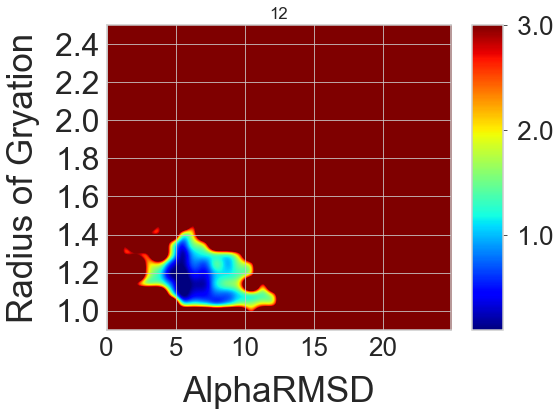

<Figure size 432x288 with 0 Axes>

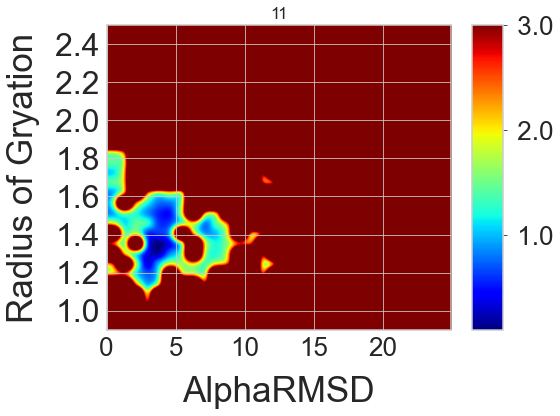

<Figure size 432x288 with 0 Axes>

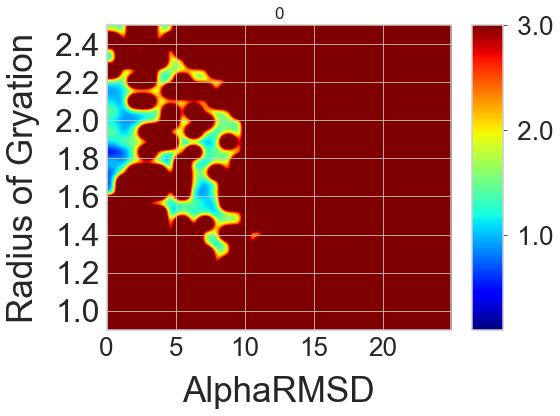

<Figure size 432x288 with 0 Axes>

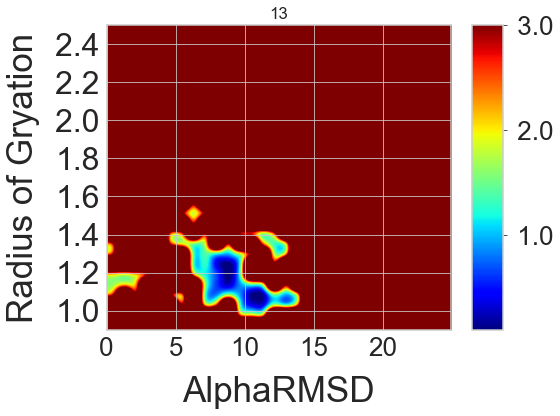

<Figure size 432x288 with 0 Axes>

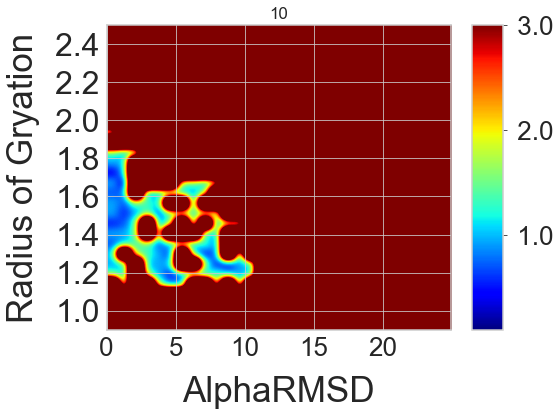

<Figure size 432x288 with 0 Axes>

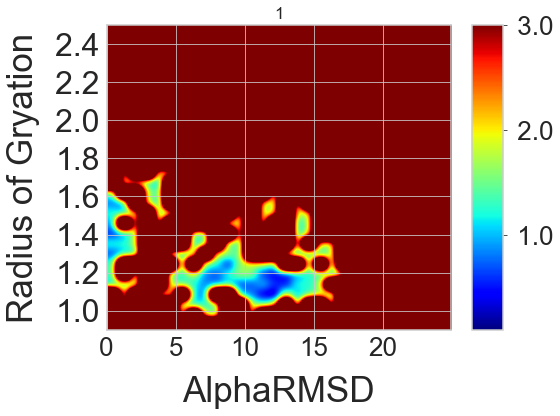

<Figure size 432x288 with 0 Axes>

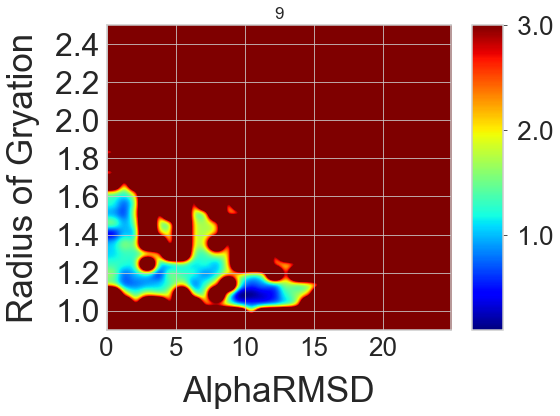

<Figure size 432x288 with 0 Axes>

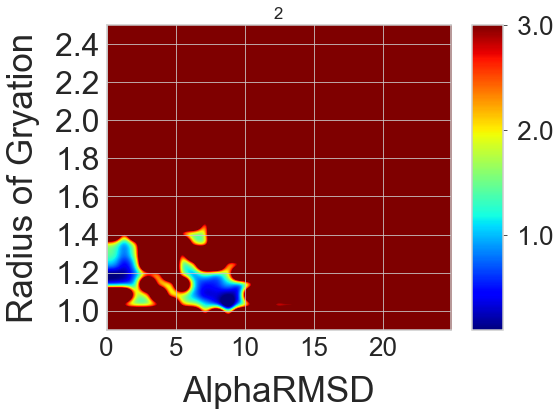

<Figure size 432x288 with 0 Axes>

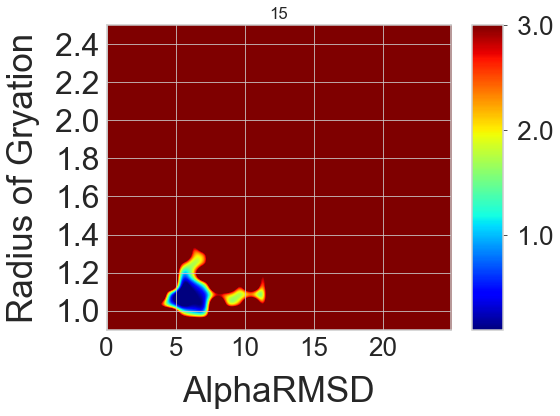

<Figure size 432x288 with 0 Axes>

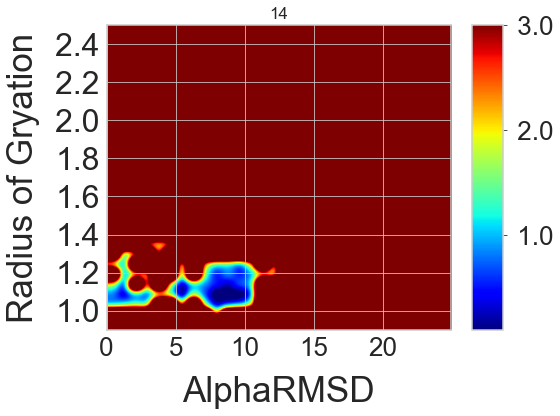

<Figure size 432x288 with 0 Axes>

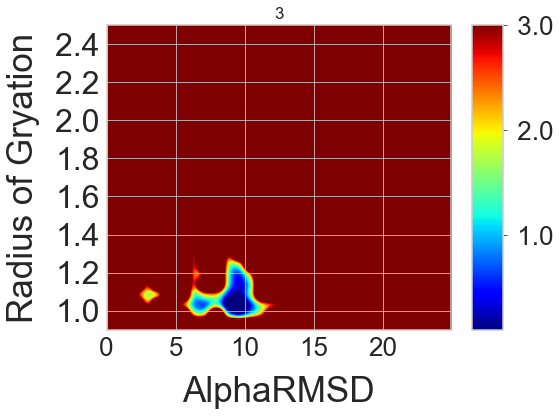

<Figure size 432x288 with 0 Axes>

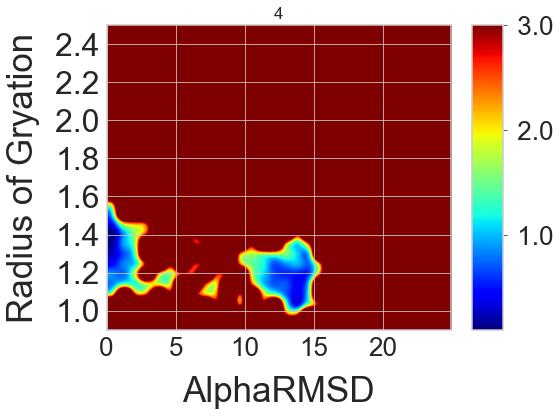

<Figure size 432x288 with 0 Axes>

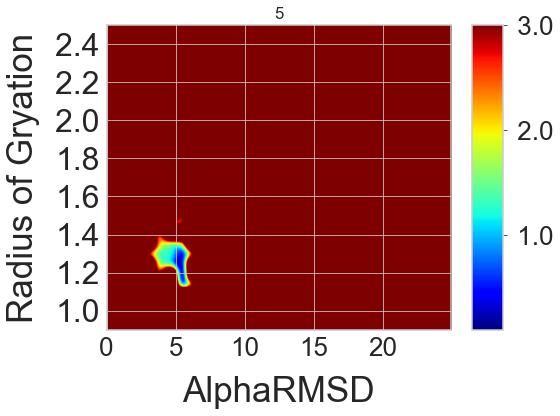

<Figure size 432x288 with 0 Axes>

In [211]:
for key in c_dict:
 frame_ind=c_dict[key]
 a,xedges,yedges=np.histogram2d(rg_CA[frame_ind],Sa_total[frame_ind],30,[[0.9,2.5],[0,25.0]],normed=True,weights=None)
 a=np.log(np.flipud(a)+.000001)
 T=300
 a=-(0.001987*T)*a

 fig=plt.figure(figsize=(8,6))
 im=plt.imshow(a, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()
 plt.xlim(0,24.9)  

 plt.ylabel("Radius of Gryation",size=35,labelpad=15)
 plt.xlabel("AlphaRMSD",size=35,labelpad=15)
 plt.xticks(fontsize=35)
 plt.yticks(fontsize=35)
 plt.xticks(size='26')
 plt.yticks(size='32')
 plt.title('%s'%key)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=3.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 plt.clf()   

In [268]:
for key in c_dict:
   print(trj[c_dict[key]])
   trj[c_dict[key]].save_dcd("tsne_clusters_perp300_k16/%s.dcd"%key)
   trj[c_dict[key][0]].save_pdb("tsne_clusters_perp300_k16/%s.pdb"%key)


<mdtraj.Trajectory with 206 frames, 739 atoms, 58 residues, and unitcells>
<mdtraj.Trajectory with 349 frames, 739 atoms, 58 residues, and unitcells>
<mdtraj.Trajectory with 239 frames, 739 atoms, 58 residues, and unitcells>
<mdtraj.Trajectory with 408 frames, 739 atoms, 58 residues, and unitcells>
<mdtraj.Trajectory with 311 frames, 739 atoms, 58 residues, and unitcells>
<mdtraj.Trajectory with 325 frames, 739 atoms, 58 residues, and unitcells>
<mdtraj.Trajectory with 312 frames, 739 atoms, 58 residues, and unitcells>
<mdtraj.Trajectory with 220 frames, 739 atoms, 58 residues, and unitcells>
<mdtraj.Trajectory with 360 frames, 739 atoms, 58 residues, and unitcells>
<mdtraj.Trajectory with 395 frames, 739 atoms, 58 residues, and unitcells>
<mdtraj.Trajectory with 282 frames, 739 atoms, 58 residues, and unitcells>
<mdtraj.Trajectory with 498 frames, 739 atoms, 58 residues, and unitcells>
<mdtraj.Trajectory with 357 frames, 739 atoms, 58 residues, and unitcells>
<mdtraj.Trajectory with 5

In [ ]:
trj